In [1]:
import pickle
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import glob as glob
import os
import sys; sys.path.append("../../..")  # Allows access to all the scripts/modules in the larger directory
from utils import calc_loadings
from collections import defaultdict
from scipy.linalg import subspace_angles
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr

In [2]:
manual_dimesnsion = 21

### Load consolidated dimreduc dataframe

In [3]:
path = '/home/marcush/Data/TsaoLabData/neural_control_output/degraded_dimreduc_param_search/degraded_dimreduc_param_search_glom.pickle'
with open(path, 'rb') as f:
    dat = pickle.load(f) 
df_dimreduc = pd.DataFrame(dat) 

### Load the processed data from both regions

In [4]:
def make_hashable(d):
    return tuple(sorted((key, make_hashable(value)) if isinstance(value, dict) else (key, value)
                        for key, value in d.items()))


unique_hashes = set(make_hashable(d) for d in df_dimreduc['loader_args'])
unique_dicts = [dict(u) for u in unique_hashes]

for u in unique_dicts:
    u['data_path'] = df_dimreduc['data_path'][0] + "/" + df_dimreduc['data_file'][0]
    u['spike_threshold'] = None
    u['trial_threshold'] = None

In [5]:
preload_dict_path = df_dimreduc['data_path'][0] + "/preloaded/preloadDict.pickle"

with open(preload_dict_path, 'rb') as file:
    preloadDict = pickle.load(file)


for arg_dict in unique_dicts:
    arg_tuple = tuple(sorted(arg_dict.items()))


    for args in preloadDict.keys():

        if args == arg_tuple:

            preloadID = preloadDict[arg_tuple]
            loaded_data_path = os.path.dirname(preload_dict_path) + f"/preloaded_data_{preloadID}.pickle"
            
            if arg_dict['region'] == 'AM':
                with open(loaded_data_path, 'rb') as file:
                    AM_loaded_data = pickle.load(file)

            elif arg_dict['region'] == 'ML':
                with open(loaded_data_path, 'rb') as file:
                    ML_loaded_data = pickle.load(file)


##### Sum spike rate per trial

In [6]:
AM_spikes = np.sum(AM_loaded_data['spike_rates'], 1)
ML_spikes = np.sum(ML_loaded_data['spike_rates'], 1)


all_spikes = {'AM':AM_spikes, 'ML':ML_spikes}

### Load CCA model

In [7]:
np.shape(AM_spikes), np.shape(ML_spikes)

((1991, 371), (1991, 570))

In [8]:
ccamodel_dir = df_dimreduc['results_file'][0]
CCA_dims = manual_dimesnsion #None

if CCA_dims == None:
    ccamodel_path = glob.glob(ccamodel_dir+"/CCA_*.pickle")[0]
else:
    ccamodel_path = os.path.dirname(ccamodel_dir)+f"/CCA_{CCA_dims}_dims.pickle"

with open(ccamodel_path, 'rb') as file:
    ccamodel = pickle.load(file)

/home/marcush/Data/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator CCA from version 1.4.1.post1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [9]:
dimensions = np.unique(df_dimreduc['dim'])
n_folds = np.unique(df_dimreduc['fold_idx'])
regions = np.unique(df_dimreduc['loader_args'].apply(lambda x: x.get('region')))
dimreduc_methods = np.unique(df_dimreduc['dimreduc_method'])
proj_methods = np.append(dimreduc_methods, 'CCA')

# Using ideal dimension for across region comparison

In [15]:
DIM = manual_dimesnsion
all_comparisons_0_1 = []
all_comparisons_1_0 = []

proj_correlations = {}


combo_ind = 0
region_method_pairs = set()  # Set to keep track of seen combinations
for region0, region1, method0, method1 in itertools.product(regions, regions, proj_methods, proj_methods):
    sorted_0 = tuple(sorted([region0, method0]))
    sorted_1 = tuple(sorted([region1, method1]))
    
    combo = (tuple(sorted((sorted_0, sorted_1))))
    
    if combo in region_method_pairs:
        continue  
    elif region0 == region1 and method0 == method1:
        continue
    region_method_pairs.add(combo)
    

    n_fold_r2_0_1 = np.zeros(len(n_folds))
    n_fold_r2_1_0 = np.zeros(len(n_folds))
    avg_correlations = np.zeros(len(n_folds))
    
    
    for n_fold in n_folds:

        if method0 == 'CCA' and method1 == 'CCA':

            if region0 == 'ML':
                ProjMat0 = ccamodel.x_rotations_
                ProjMat1 = ccamodel.y_rotations_

            elif region0 == 'AM':
                ProjMat0 = ccamodel.y_rotations_
                ProjMat1 = ccamodel.x_rotations_

        elif method0 == 'CCA':
            ProjMat1 = df_dimreduc[(df_dimreduc['loader_args'].apply(lambda x: x.get('region')) == region1) & (df_dimreduc['dim'] == DIM) & (df_dimreduc['fold_idx'] == n_fold) & (df_dimreduc['dimreduc_method'] == method1)]['coef'].iloc[0]
            if region0 == 'ML':
                ProjMat0 = ccamodel.x_rotations_
            elif region0 == 'AM':
                ProjMat0 = ccamodel.y_rotations_

        elif method1 == 'CCA':
            ProjMat0 = df_dimreduc[(df_dimreduc['loader_args'].apply(lambda x: x.get('region')) == region0) & (df_dimreduc['dim'] == DIM) & (df_dimreduc['fold_idx'] == n_fold) & (df_dimreduc['dimreduc_method'] == method0)]['coef'].iloc[0]
            if region1 == 'ML':
                ProjMat1 = ccamodel.x_rotations_
            elif region1 == 'AM':
                ProjMat1 = ccamodel.y_rotations_
        else:
            ProjMat0 = df_dimreduc[(df_dimreduc['loader_args'].apply(lambda x: x.get('region')) == region0) & (df_dimreduc['dim'] == DIM) & (df_dimreduc['fold_idx'] == n_fold) & (df_dimreduc['dimreduc_method'] == method0)]['coef'].iloc[0]
            ProjMat1 = df_dimreduc[(df_dimreduc['loader_args'].apply(lambda x: x.get('region')) == region1) & (df_dimreduc['dim'] == DIM) & (df_dimreduc['fold_idx'] == n_fold) & (df_dimreduc['dimreduc_method'] == method1)]['coef'].iloc[0]

        projData0 = all_spikes[region0] @ ProjMat0[:,0:DIM]
        projData1 = all_spikes[region1] @ ProjMat1[:,0:DIM]


        model_0_1 = LinearRegression()
        model_0_1.fit(projData0, projData1)
        r2_0_1 = model_0_1.score(projData0, projData1)
        
        model_1_0 = LinearRegression()
        model_1_0.fit(projData1, projData0)
        r2_1_0 = model_1_0.score(projData1, projData0)

        correlations = []
        for row_x, row_y in zip(projData0, projData1):
            corr, _ = pearsonr(row_x, row_y)
            correlations.append(corr)
        average_correlation = np.mean(correlations)


        avg_correlations[n_fold] = average_correlation
        n_fold_r2_0_1[n_fold] = r2_0_1
        n_fold_r2_1_0[n_fold] = r2_1_0

        

    R2_avg_0_1 = np.mean(n_fold_r2_0_1)
    R2_avg_1_0 = np.mean(n_fold_r2_1_0)

    all_comparisons_0_1.append(R2_avg_0_1)
    all_comparisons_1_0.append(R2_avg_1_0)

    #models[f"{region0}_{method0}_{region1}_{method1}"] = model_0_1
    proj_correlations[f"{region0}_{method0}_{region1}_{method1}"] = np.mean(avg_correlations)
        
    combo_ind += 1



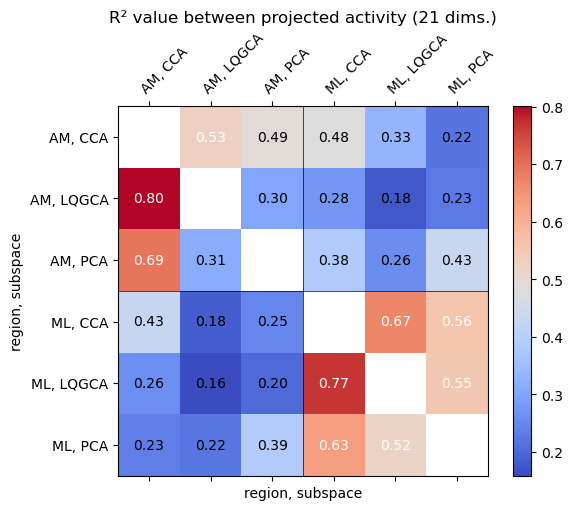

In [17]:
import numpy as np
import matplotlib.pyplot as plt

unique_groups = [('AM', 'CCA'), ('AM', 'LQGCA'), ('AM', 'PCA'), ('ML', 'CCA'), ('ML', 'LQGCA'), ('ML', 'PCA')]
group_indices = {group: i for i, group in enumerate(unique_groups)}

n = 6  # We have 6 unique groups
matrix = np.zeros((n, n))  # Initialize the matrix with zeros

correlation_index = 0
for i in range(n):
    for j in range(i + 1, n):
        matrix[i, j] = all_comparisons_0_1[correlation_index]
        matrix[j, i] = all_comparisons_1_0[correlation_index]  # Not Symmetric
        correlation_index += 1

# Set diagonal values to NaN
np.fill_diagonal(matrix, np.nan)

labels = [f"{reg}, {meth}" for reg, meth in unique_groups]

fig, ax = plt.subplots()
cax = ax.matshow(matrix, cmap='coolwarm')
plt.colorbar(cax)

ax.set_xticks(range(n))
ax.set_yticks(range(n))
ax.set_xticklabels(labels, rotation=45, ha="left", rotation_mode="anchor")
ax.set_yticklabels(labels)

# Annotate each cell with the numeric value
for (i, j), val in np.ndenumerate(matrix):
    if not np.isnan(val):  # Skip NaN values
        ax.text(j, i, f"{val:.2f}", ha='center', va='center', color='white' if abs(val) > 0.5 else 'black')

midpoint = n / 2
ax.axhline(midpoint - 0.5, color='black', linewidth=0.5)  # Horizontal line
ax.axvline(midpoint - 0.5, color='black', linewidth=0.5)  # Vertical line

plt.title(f'R² value between projected activity ({manual_dimesnsion} dims.)')
plt.xlabel('region, subspace')
plt.ylabel('region, subspace')
plt.show()


# Using within region maximal dimensions

In [18]:
shared_opt_dim = 25
AM_opt_dim = 39
ML_opt_dim = 21

opt_dims = {'AM': AM_opt_dim, 'ML': ML_opt_dim}

In [19]:
ccamodel_dir = df_dimreduc['results_file'][0]

ccamodel_path = os.path.dirname(ccamodel_dir)+f"/CCA_{shared_opt_dim}_dims.pickle"
with open(ccamodel_path, 'rb') as file:
    ccamodel_bothRegions = pickle.load(file)

ccamodel_path = os.path.dirname(ccamodel_dir)+f"/CCA_{AM_opt_dim}_dims.pickle"
with open(ccamodel_path, 'rb') as file:
    ccamodel_AM = pickle.load(file)

ccamodel_path = os.path.dirname(ccamodel_dir)+f"/CCA_{ML_opt_dim}_dims.pickle"
with open(ccamodel_path, 'rb') as file:
    ccamodel_ML = pickle.load(file)

/home/marcush/Data/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator CCA from version 1.4.1.post1 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [20]:
DIM = manual_dimesnsion
all_comparisons_0_1_alt = []
all_comparisons_1_0_alt = []

proj_correlations = {}


combo_ind = 0
region_method_pairs = set()  # Set to keep track of seen combinations
for region0, region1, method0, method1 in itertools.product(regions, regions, proj_methods, proj_methods):
    sorted_0 = tuple(sorted([region0, method0]))
    sorted_1 = tuple(sorted([region1, method1]))
    
    combo = (tuple(sorted((sorted_0, sorted_1))))

    
    if combo in region_method_pairs:
        continue  
    elif region0 == region1 and method0 == method1:
        continue
    region_method_pairs.add(combo)
    

    n_fold_r2_0_1 = np.zeros(len(n_folds))
    n_fold_r2_1_0 = np.zeros(len(n_folds))
    avg_correlations = np.zeros(len(n_folds))
    
    
    for n_fold in n_folds:

        if region0 == 'ML' and region1 == 'ML':
            ccamod = ccamodel_ML
            if method0 == 'CCA' and method1 == 'CCA':

                if region0 == 'ML':
                    ProjMat0 = ccamod.x_rotations_
                    ProjMat1 = ccamod.y_rotations_

                elif region0 == 'AM':
                    ProjMat0 = ccamod.y_rotations_
                    ProjMat1 = ccamod.x_rotations_

            elif method0 == 'CCA':
                ProjMat1 = df_dimreduc[(df_dimreduc['loader_args'].apply(lambda x: x.get('region')) == region1) & (df_dimreduc['dim'] == opt_dims[region1]) & (df_dimreduc['fold_idx'] == n_fold) & (df_dimreduc['dimreduc_method'] == method1)]['coef'].iloc[0]
                if region0 == 'ML':
                    ProjMat0 = ccamod.x_rotations_
                elif region0 == 'AM':
                    ProjMat0 = ccamod.y_rotations_

            elif method1 == 'CCA':
                ProjMat0 = df_dimreduc[(df_dimreduc['loader_args'].apply(lambda x: x.get('region')) == region0) & (df_dimreduc['dim'] == opt_dims[region0]) & (df_dimreduc['fold_idx'] == n_fold) & (df_dimreduc['dimreduc_method'] == method0)]['coef'].iloc[0]
                if region1 == 'ML':
                    ProjMat1 = ccamod.x_rotations_
                elif region1 == 'AM':
                    ProjMat1 = ccamod.y_rotations_
            else:
                ProjMat0 = df_dimreduc[(df_dimreduc['loader_args'].apply(lambda x: x.get('region')) == region0) & (df_dimreduc['dim'] == opt_dims[region0]) & (df_dimreduc['fold_idx'] == n_fold) & (df_dimreduc['dimreduc_method'] == method0)]['coef'].iloc[0]
                ProjMat1 = df_dimreduc[(df_dimreduc['loader_args'].apply(lambda x: x.get('region')) == region1) & (df_dimreduc['dim'] == opt_dims[region1]) & (df_dimreduc['fold_idx'] == n_fold) & (df_dimreduc['dimreduc_method'] == method1)]['coef'].iloc[0]

        elif region0 == 'AM' and region1 == 'AM':
            ccamod = ccamodel_AM
            if method0 == 'CCA' and method1 == 'CCA':

                if region0 == 'ML':
                    ProjMat0 = ccamod.x_rotations_
                    ProjMat1 = ccamod.y_rotations_

                elif region0 == 'AM':
                    ProjMat0 = ccamod.y_rotations_
                    ProjMat1 = ccamod.x_rotations_

            elif method0 == 'CCA':
                ProjMat1 = df_dimreduc[(df_dimreduc['loader_args'].apply(lambda x: x.get('region')) == region1) & (df_dimreduc['dim'] == opt_dims[region1]) & (df_dimreduc['fold_idx'] == n_fold) & (df_dimreduc['dimreduc_method'] == method1)]['coef'].iloc[0]
                if region0 == 'ML':
                    ProjMat0 = ccamod.x_rotations_
                elif region0 == 'AM':
                    ProjMat0 = ccamod.y_rotations_

            elif method1 == 'CCA':
                ProjMat0 = df_dimreduc[(df_dimreduc['loader_args'].apply(lambda x: x.get('region')) == region0) & (df_dimreduc['dim'] == opt_dims[region0]) & (df_dimreduc['fold_idx'] == n_fold) & (df_dimreduc['dimreduc_method'] == method0)]['coef'].iloc[0]
                if region1 == 'ML':
                    ProjMat1 = ccamod.x_rotations_
                elif region1 == 'AM':
                    ProjMat1 = ccamod.y_rotations_
            else:
                ProjMat0 = df_dimreduc[(df_dimreduc['loader_args'].apply(lambda x: x.get('region')) == region0) & (df_dimreduc['dim'] == opt_dims[region0]) & (df_dimreduc['fold_idx'] == n_fold) & (df_dimreduc['dimreduc_method'] == method0)]['coef'].iloc[0]
                ProjMat1 = df_dimreduc[(df_dimreduc['loader_args'].apply(lambda x: x.get('region')) == region1) & (df_dimreduc['dim'] == opt_dims[region1]) & (df_dimreduc['fold_idx'] == n_fold) & (df_dimreduc['dimreduc_method'] == method1)]['coef'].iloc[0]

        else:
            ccamod = ccamodel_bothRegions

            if method0 == 'CCA' and method1 == 'CCA':
                if region0 == 'ML':
                    ProjMat0 = ccamod.x_rotations_
                    ProjMat1 = ccamod.y_rotations_

                elif region0 == 'AM':
                    ProjMat0 = ccamod.y_rotations_
                    ProjMat1 = ccamod.x_rotations_

            elif method0 == 'CCA':
                ProjMat1 = df_dimreduc[(df_dimreduc['loader_args'].apply(lambda x: x.get('region')) == region1) & (df_dimreduc['dim'] == shared_opt_dim) & (df_dimreduc['fold_idx'] == n_fold) & (df_dimreduc['dimreduc_method'] == method1)]['coef'].iloc[0]
                if region0 == 'ML':
                    ProjMat0 = ccamod.x_rotations_
                elif region0 == 'AM':
                    ProjMat0 = ccamod.y_rotations_

            elif method1 == 'CCA':
                ProjMat0 = df_dimreduc[(df_dimreduc['loader_args'].apply(lambda x: x.get('region')) == region0) & (df_dimreduc['dim'] == shared_opt_dim) & (df_dimreduc['fold_idx'] == n_fold) & (df_dimreduc['dimreduc_method'] == method0)]['coef'].iloc[0]
                if region1 == 'ML':
                    ProjMat1 = ccamod.x_rotations_
                elif region1 == 'AM':
                    ProjMat1 = ccamod.y_rotations_
            else:
                ProjMat0 = df_dimreduc[(df_dimreduc['loader_args'].apply(lambda x: x.get('region')) == region0) & (df_dimreduc['dim'] == shared_opt_dim) & (df_dimreduc['fold_idx'] == n_fold) & (df_dimreduc['dimreduc_method'] == method0)]['coef'].iloc[0]
                ProjMat1 = df_dimreduc[(df_dimreduc['loader_args'].apply(lambda x: x.get('region')) == region1) & (df_dimreduc['dim'] == shared_opt_dim) & (df_dimreduc['fold_idx'] == n_fold) & (df_dimreduc['dimreduc_method'] == method1)]['coef'].iloc[0]


        projData0 = all_spikes[region0] @ ProjMat0
        projData1 = all_spikes[region1] @ ProjMat1


        model_0_1 = LinearRegression()
        model_0_1.fit(projData0, projData1)
        r2_0_1 = model_0_1.score(projData0, projData1)
        
        model_1_0 = LinearRegression()
        model_1_0.fit(projData1, projData0)
        r2_1_0 = model_1_0.score(projData1, projData0)

        correlations = []
        for row_x, row_y in zip(projData0, projData1):
            corr, _ = pearsonr(row_x, row_y)
            correlations.append(corr)
        average_correlation = np.mean(correlations)


        avg_correlations[n_fold] = average_correlation
        n_fold_r2_0_1[n_fold] = r2_0_1
        n_fold_r2_1_0[n_fold] = r2_1_0


    R2_avg_0_1 = np.mean(n_fold_r2_0_1)
    R2_avg_1_0 = np.mean(n_fold_r2_1_0)

    all_comparisons_0_1_alt.append(R2_avg_0_1)
    all_comparisons_1_0_alt.append(R2_avg_1_0)

    #models[f"{region0}_{method0}_{region1}_{method1}"] = model_0_1
    proj_correlations[f"{region0}_{method0}_{region1}_{method1}"] = np.mean(avg_correlations)
        
    combo_ind += 1



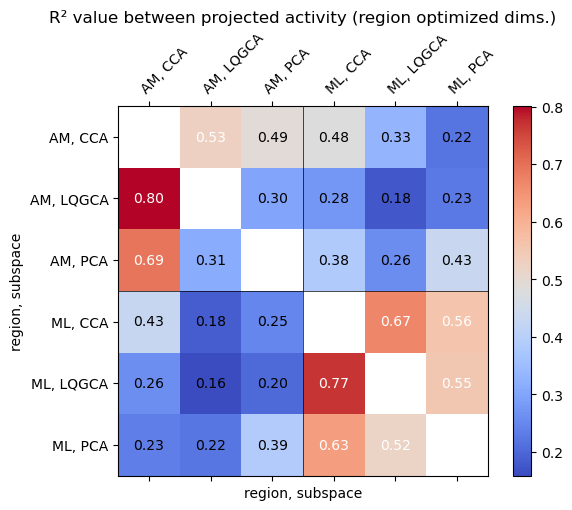

In [23]:
import numpy as np
import matplotlib.pyplot as plt

unique_groups = [('AM', 'CCA'), ('AM', 'LQGCA'), ('AM', 'PCA'), ('ML', 'CCA'), ('ML', 'LQGCA'), ('ML', 'PCA')]
group_indices = {group: i for i, group in enumerate(unique_groups)}

n = 6  # We have 6 unique groups
matrix = np.zeros((n, n))  # Initialize the matrix with zeros

correlation_index = 0
for i in range(n):
    for j in range(i + 1, n):
        matrix[i, j] = all_comparisons_0_1[correlation_index]
        matrix[j, i] = all_comparisons_1_0[correlation_index]  # Not Symmetric
        correlation_index += 1

# Set diagonal values to NaN
np.fill_diagonal(matrix, np.nan)

labels = [f"{reg}, {meth}" for reg, meth in unique_groups]

fig, ax = plt.subplots()
cax = ax.matshow(matrix, cmap='coolwarm')
plt.colorbar(cax)

ax.set_xticks(range(n))
ax.set_yticks(range(n))
ax.set_xticklabels(labels, rotation=45, ha="left", rotation_mode="anchor")
ax.set_yticklabels(labels)

# Annotate each cell with the numeric value
for (i, j), val in np.ndenumerate(matrix):
    if not np.isnan(val):  # Skip NaN values
        ax.text(j, i, f"{val:.2f}", ha='center', va='center', color='white' if abs(val) > 0.5 else 'black')

midpoint = n / 2
ax.axhline(midpoint - 0.5, color='black', linewidth=0.5)  # Horizontal line
ax.axvline(midpoint - 0.5, color='black', linewidth=0.5)  # Vertical line

plt.title(f'R² value between projected activity (region optimized dims.)')
plt.xlabel('region, subspace')
plt.ylabel('region, subspace')
plt.show()


## For comparing CCA subspaces


In [14]:
from sklearn.cross_decomposition import CCA

manual_CCA_dim = np.inf

cca_dims = np.min((manual_CCA_dim, AM_spikes.shape[-1], ML_spikes.shape[-1])).astype(int)

ccamodel = CCA(n_components=cca_dims)
ccamodel.fit(ML_spikes, AM_spikes)
score = ccamodel.score(ML_spikes, AM_spikes)


/home/marcush/Data/anaconda3/envs/ncontrol/lib/python3.9/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


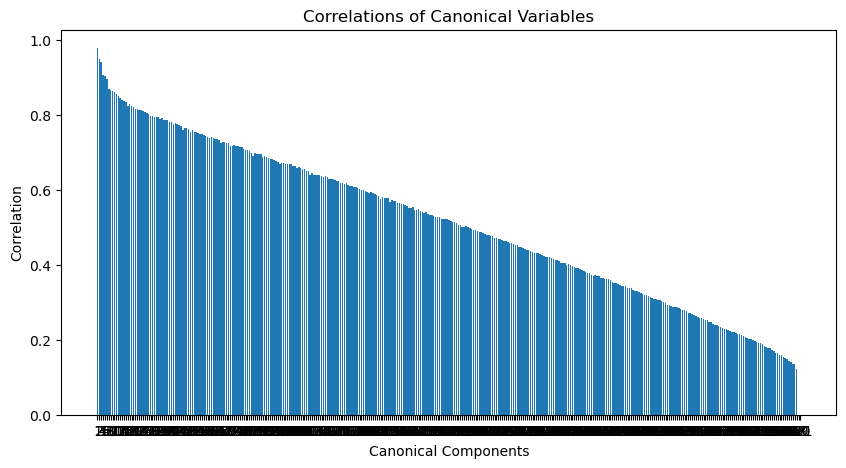

In [15]:
X = ML_spikes
Y = AM_spikes
X_c, Y_c = ccamodel.transform(X, Y)

# Calculate correlations between each pair of canonical variables
correlations = np.array([np.corrcoef(X_c[:, i], Y_c[:, i])[0, 1] for i in range(X_c.shape[1])])

# Plotting the canonical correlations
plt.figure(figsize=(10, 5))
plt.bar(range(1, len(correlations) + 1), correlations)
plt.xlabel('Canonical Components')
plt.ylabel('Correlation')
plt.title('Correlations of Canonical Variables')
plt.xticks(range(1, len(correlations) + 1))
plt.show()


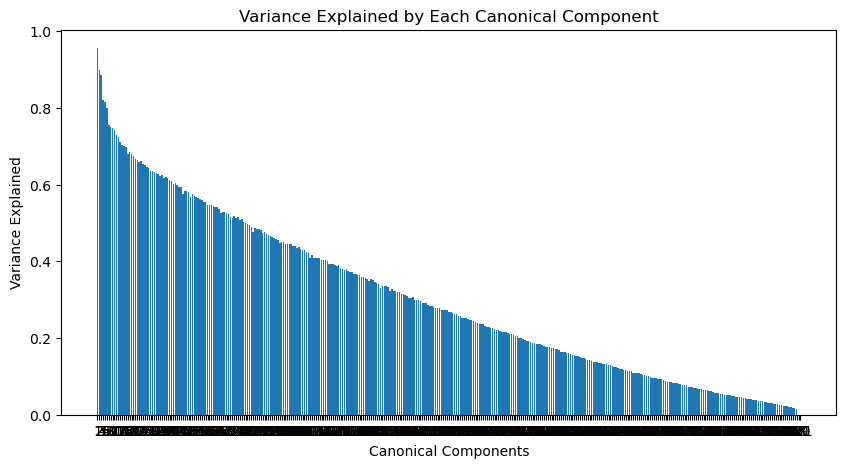

In [16]:
# Variance explained by each component is the square of the canonical correlations
variance_explained = correlations**2

plt.figure(figsize=(10, 5))
plt.bar(range(1, len(variance_explained) + 1), variance_explained)
plt.xlabel('Canonical Components')
plt.ylabel('Variance Explained')
plt.title('Variance Explained by Each Canonical Component')
plt.xticks(range(1, len(variance_explained) + 1))
plt.show()
